# Script per la stima di $g$

## Importing libraries

In [17]:
from os import listdir

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from modules import functions

plt.style.use("modules/mystyle.mplstyle")

## Importing data

### Get the datasets for fotogate

In [18]:
# * Nomi dei datasets per il fotogate datasets_names_mattia
dataset_names_mattia = [
    f"misura fototraguardo lunghezza {'1(min)' if i == 0 else f'{i+1}_tia'}"
    for i in range(5)
]
# da "Misure accel grav giorno2.xlsx"
lunghezze_associate_mattia = [206.10, 172.58, 128.24, 99.22, 67.90]

dataset_names_matilde = [
    f"misura fototraguardo lunghezza {f'{i+1}_mat'}" for i in range(1, 5)
]
# da "Misure accel grav giorno2.xlsx"
lunghezze_associate_matilde = [172.58, 127.06, 99.08, 67.86]

dataset_names_filippo = [
    f"misura fototraguardo lunghezza {f'{i+1}_fil'}" for i in range(2, 5)
]
# da "Misure accel grav giorno2.xlsx"
lunghezze_associate_filippo = [127.46, 99.06, 67.56]

dataset_different_angles = [
    "misure fototraguardo, angoli diversi, 3-5-7-10-15 gradi",
]
# da "Misure accel grav giorno2.xlsx"
lunghezze_associate_angoli = [30.00]

### Load all data

In [19]:
data_crono_mattia = pd.read_excel(
    "data/Misure accel grav giorno2.xlsx", sheet_name="Mattia"
)
data_crono_matilde = pd.read_excel(
    "data/Misure accel grav giorno2.xlsx", sheet_name="Matilde"
)
data_crono_filippo = pd.read_excel(
    "data/Misure accel grav giorno2.xlsx", sheet_name="Filippo"
)

data_cronos = [data_crono_mattia, data_crono_matilde, data_crono_filippo]

# ! come lo faccio decentemente per il fotogate?
# data_fotogate = pd.read_csv()

## Analysis

### For the cronometer

~~~ Set Cronometro Mattia ~~~
g = -9831.4±12.6 mm/s^2
T squared sperimental:  [1.53590474 1.67141645 1.85292261 1.96554237 2.09429313 2.24257025]
T squared regression:  [-1.50063034 -1.63523186 -1.81328171 -1.92981322 -2.0555805  -2.20777017]
T squared difference [0.0352744  0.03618459 0.0396409  0.03572916 0.03871262 0.03480008]
~~~ Set Cronometro Matilde ~~~
g = -9920.6±10.0 mm/s^2
T squared sperimental:  [1.54144807 1.67372193 1.85521696 1.96520003 2.09051347 2.24410643]
T squared regression:  [-1.48713856 -1.62052991 -1.80167472 -1.91301988 -2.03725848 -2.18951245]
T squared difference [0.05430951 0.05319202 0.05354224 0.05218014 0.05325499 0.05459398]
~~~ Set Cronometro Filippo ~~~
g = -9894.7±9.5 mm/s^2
T squared sperimental:  [1.54123585 1.67264795 1.85621494 1.9657478  2.09309175 2.24740002]
T squared regression:  [-1.49102441 -1.6247643  -1.8047865  -1.91809835 -2.04377874 -2.19682953]
T squared difference [0.05021144 0.04788364 0.05142844 0.04764945 0.04931301 0.05057049]


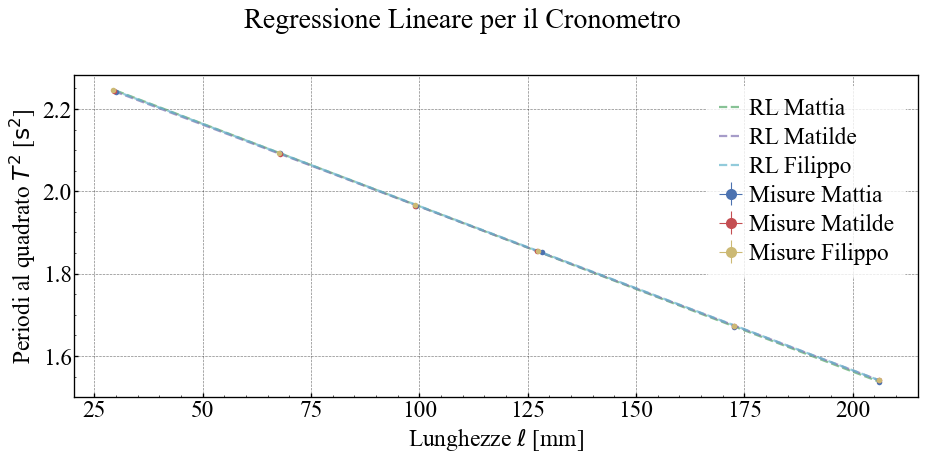

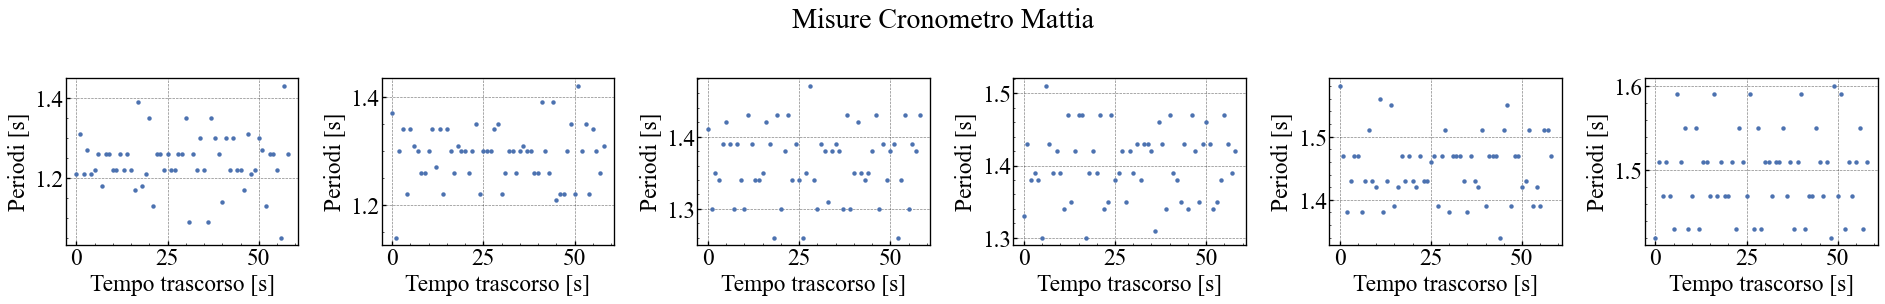

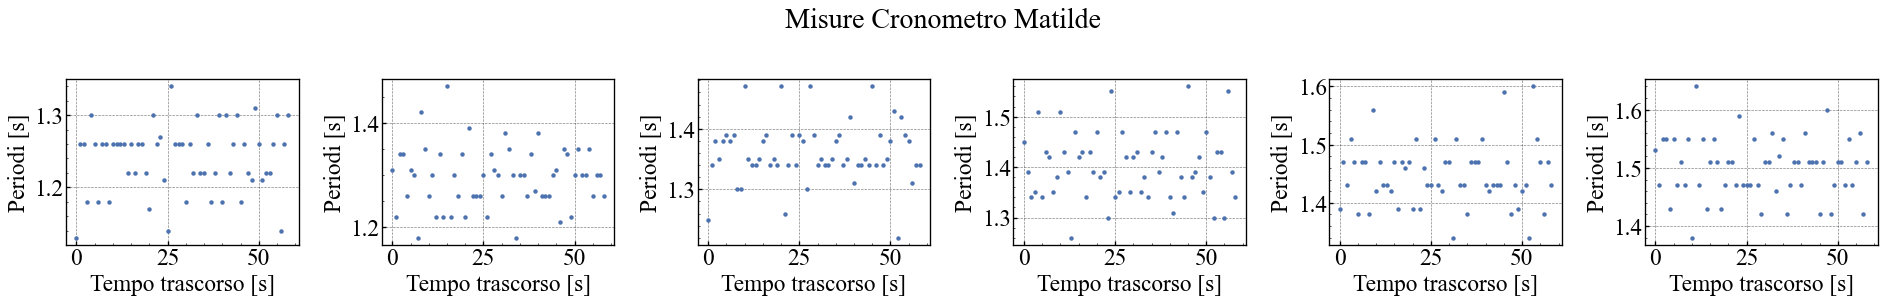

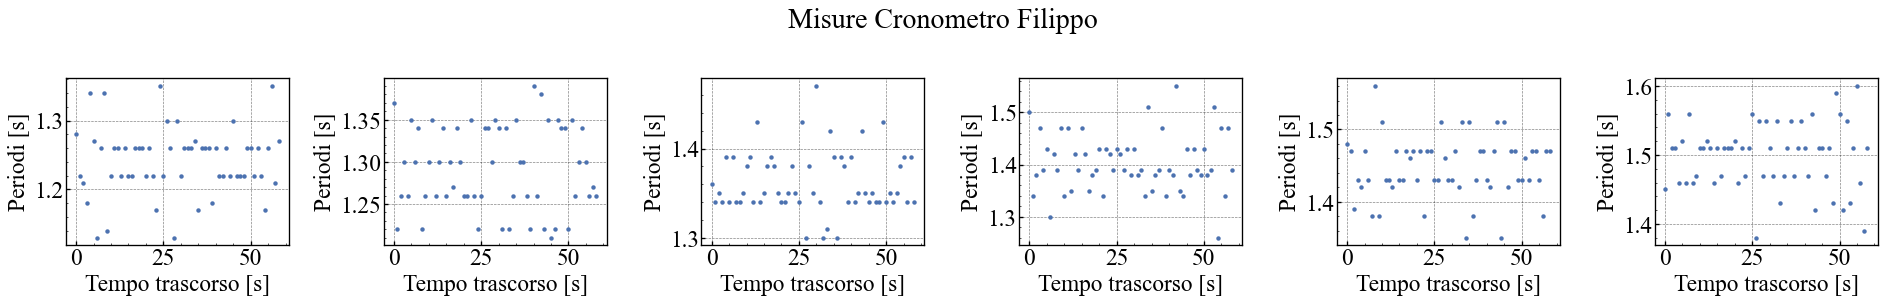

In [20]:
names = ["Mattia", "Matilde", "Filippo"]

Fig, AX = plt.subplots(figsize=(12, 6))
plt.suptitle("Regressione Lineare per il Cronometro")
AX.set_xlabel(r"Lunghezze $\ell$ [mm]")
AX.set_ylabel(r"Periodi al quadrato $T^2$ [$\text{s}^2$]")

for i, dataset in enumerate(data_cronos):
    X = dataset.columns.values
    periods = dataset.T.to_numpy()
    mean_periods, std_periods = functions.calc_moving_average(periods)

    # * show sets
    fig, ax = plt.subplots(1, 6, figsize=(24, 4))
    plt.suptitle(f"Misure Cronometro {names[i]}")
    for j, set in enumerate(periods):
        ax[j].scatter(np.arange(len(set)), set)
        ax[j].set_xlabel(r"Tempo trascorso [s]")
        ax[j].set_ylabel(r"Periodi [s]")

    Y = np.square(mean_periods)
    Yerr = 2 * np.multiply(mean_periods, std_periods)

    AX.errorbar(
        X,
        Y,
        Yerr,
        xerr=0.02,
        ls="",
        marker=".",
        label=f"Misure {names[i]}",
        markersize=10
    )

    params, uncert = functions.calc_reg_lin(X, Y, Yerr)

    g_value = (4 * np.pi**2) / params[0]
    g_uncert = g_value * uncert[0] / params[0]

    print(f"~~~ Set Cronometro {names[i]} ~~~")
    print(f"g = {g_value:.1f}±{g_uncert:.1f} mm/s^2")

    X_reg = np.linspace(min(X), max(X), 100)
    Y_reg = params[0] * X_reg + params[1]
    AX.plot(X_reg, Y_reg, alpha=0.7, ls="--", label=f"RL {names[i]}", linewidth=2)

    # * check if crosses zero
    lunghezza_riferimento = 405  # mm
    X = X[0] - X + lunghezza_riferimento - functions.calc_cm()
    reg_Y = (4 * np.pi**2) * X / g_value

    print("T squared sperimental: ", Y)
    print("T squared regression: ", reg_Y)
    print("T squared difference", abs(Y) - abs(reg_Y))
    # ! c'è errore sistematico
    # ? come lo tolgo?
    # TODO stimare l'incertezza dell'errore sistematico
    # * ho 1cm di errore sistematico sulla lunghezza di riferimento



AX.legend()
Fig.savefig("images/Regressione Lineare Cronometro.svg")

## Per il fotogate

### Import data

misura fototraguardo lunghezza 1(min)    mean periods: 1.2387 ± 0.0000 mean squared: 1.5345±0.0001
misura fototraguardo lunghezza 2_mat     mean periods: 1.2927 ± 0.0000 mean squared: 1.6711±0.0000
misura fototraguardo lunghezza 2_tia     mean periods: 1.2931 ± 0.0000 mean squared: 1.6722±0.0000
misura fototraguardo lunghezza 3_fil     mean periods: 1.3631 ± 0.0000 mean squared: 1.8581±0.0000
misura fototraguardo lunghezza 3_mat     mean periods: 1.3622 ± 0.0000 mean squared: 1.8557±0.0000
misura fototraguardo lunghezza 3_tia     mean periods: 1.3620 ± 0.0000 mean squared: 1.8552±0.0000
misura fototraguardo lunghezza 4_fil     mean periods: 1.4018 ± 0.0000 mean squared: 1.9650±0.0000
misura fototraguardo lunghezza 4_mat     mean periods: 1.4023 ± 0.0000 mean squared: 1.9666±0.0000
misura fototraguardo lunghezza 4_tia     mean periods: 1.4033 ± 0.0000 mean squared: 1.9692±0.0000
misura fototraguardo lunghezza 5_fil     mean periods: 1.4471 ± 0.0000 mean squared: 2.0940±0.0000
misura fot

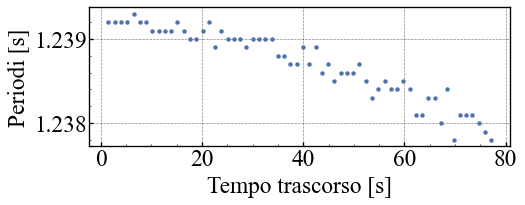

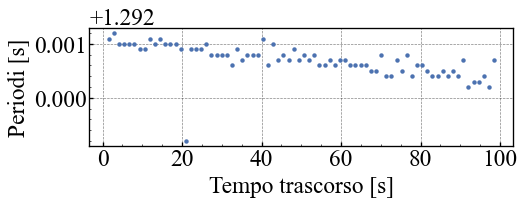

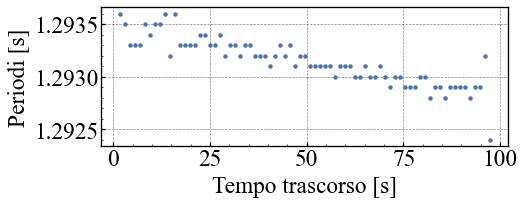

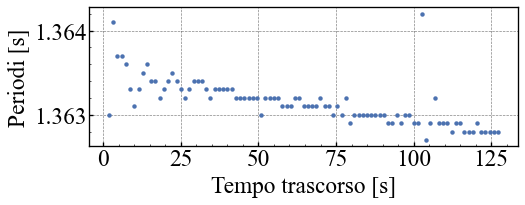

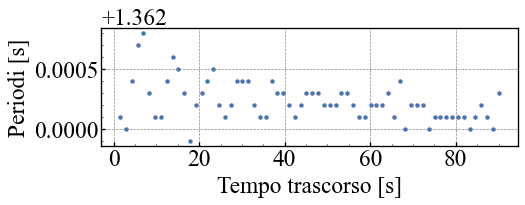

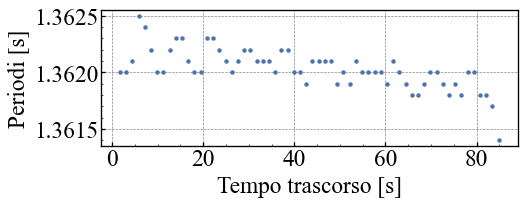

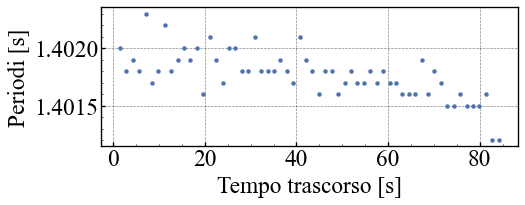

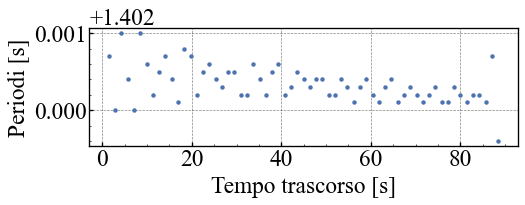

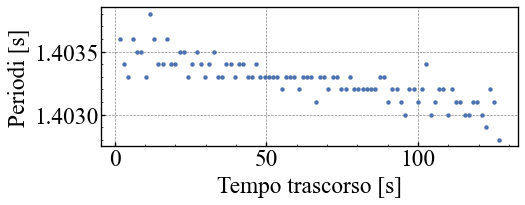

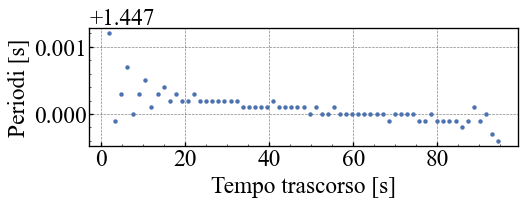

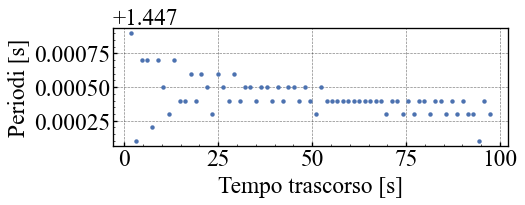

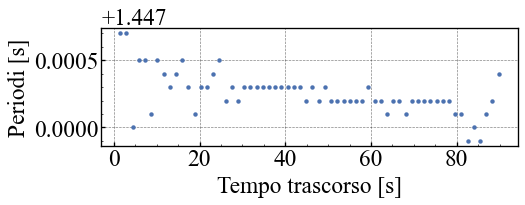

In [21]:
datasets_names = [
    f[:-4]
    for f in listdir("data")
    if f
    not in [
        ".DS_Store",
        "Misure accel grav giorno2.xlsx",
        "~$Misure accel grav giorno2.xlsx",
        "misure fototraguardo, angoli diversi, 3-5-7-10-15 gradi.csv",
        "Pendolo.xlsx",
    ]
]

lunghezze = np.array(
        [
            206.10,
            172.58,
            172.58,
            127.46,
            127.06,
            128.24,
            99.06,
            99.08,
            99.22,
            67.56,
            67.86,
            67.90,
        ]
    )

datasets_names.sort()

datasets = {}
for dataset_name in datasets_names:
    with open(f"data/{dataset_name}.csv", "r") as file:
        datasets[dataset_name] = pd.read_csv(file, sep=";", decimal=",").dropna()

periods = []
std_periods = []

for dataset_name, dataset in datasets.items():
    X = dataset.iloc[:, 0].to_numpy()
    Y = dataset.iloc[:, 1].to_numpy()

    mean_period, std_period = functions.calc_moving_average(Y)

    print(
        f"{dataset_name:<40}",
        f"mean periods: {mean_period:.4f} ± {std_period:.4f}",
        f"mean squared: {mean_period**2:.4f}±{2*std_period*mean_period:.4f}",
    )
    periods.append(mean_period)
    std_periods.append(std_period)

    plt.subplots(figsize=(7, 3))
    plt.scatter(X, Y)

    plt.xlabel(r"Tempo trascorso [s]")
    plt.ylabel(r"Periodi [s]")

periods = np.array(periods)
std_periods = np.array(std_periods)

### Analysis

### C'è da aggiungere la correzione per momento di inerzia

~~~ Set Fototraguardo (unico per tutti) ~~~
Regression parameters: -0.004035±0.000001 2.368394±0.000171
g = 9783.3±3.3 mm/s^2
T squared sperimental:  [1.53447716 1.67107791 1.67223002 1.85813962 1.85567592 1.85517947
 1.96502018 1.96655863 1.96918134 2.09405045 2.09505074 2.09453851]
T squared regression:  [1.50799577 1.64325794 1.64325794 1.82532922 1.82694332 1.82218171
 1.93993082 1.93985011 1.93928517 2.06704175 2.06583117 2.06566975]
T squared difference [0.02648139 0.02781996 0.02897208 0.0328104  0.0287326  0.03299776
 0.02508937 0.02670852 0.02989616 0.02700871 0.02921958 0.02886875]


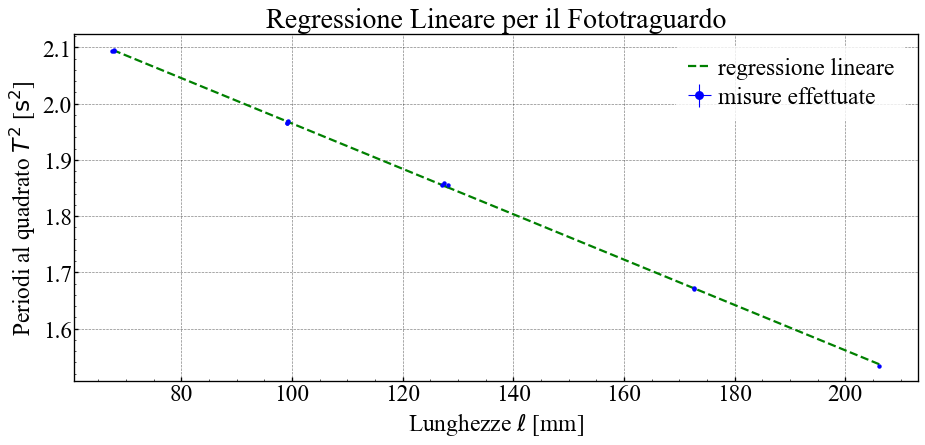

In [22]:
squared_periods = np.square(periods) * (
    1 + (0.01 / (2 * np.pi)) ** 2  # correzione smorzamento (inutile)
)
squared_p_std = 2 * np.multiply(std_periods, periods)
xerr = 0.2 / 1000
err = np.sqrt(np.square(squared_p_std) + np.square(xerr))

plt.subplots(figsize=(12, 6))
plt.errorbar(
    lunghezze,
    squared_periods,
    fmt="b. ",
    yerr=squared_p_std,
    xerr=xerr,
    label="misure effettuate",
    markersize=8
)

retta = lambda x, a, b: a * x + b

params, cov = scipy.optimize.curve_fit(
    retta, lunghezze, squared_periods, sigma=err, absolute_sigma=True
)
std = np.sqrt(np.diag(cov))

g_value = -(4 * np.pi**2) / params[0]
g_uncert = -std[0] / params[0] * g_value

plt.plot(
    lunghezze, retta(lunghezze, *params), ls="--", c="g", label="regressione lineare", linewidth=2
)

print(f"~~~ Set Fototraguardo (unico per tutti) ~~~")
print("Regression parameters:", *[f"{param:.6f}±{errs:.6f}" for param, errs in zip(params, std)])
print(f"g = {g_value:.1f}±{g_uncert:.1f} mm/s^2")

# * check if crosses zero
lunghezza_riferimento = 405  # mm ± 1
X = lunghezze[0] - lunghezze + lunghezza_riferimento - functions.calc_cm() # ±1mm
regression_y = (4 * np.pi**2) * X / g_value # ±4pi^2 * (propagazione degli errori)

print("T squared sperimental: ", squared_periods)
print("T squared regression: ", regression_y)
print("T squared difference", squared_periods - regression_y)
# ! c'è errore sistematico
# ? come lo tolgo?
# TODO stimare l'incertezza dell'errore sistematico
# * ho mezzo centimetro di errore sistematico sulla lunghezza di riferimento

plt.title("Regressione Lineare per il Fototraguardo")
plt.xlabel(r"Lunghezze $\ell$ [mm]")
plt.ylabel(r"Periodi al quadrato $T^2$ [$\text{s}^2$]")
plt.legend()

plt.savefig("images/Regressione Lineare Fototraguardo.svg")

calculate gamma $\gamma$

~~~ Set con angolo 3° ~~~
Ampiezza iniziale: 	9.694e-02 ±2.114e+00
Smorzamento gamma: 	5.085e-05 ±1.118e-03
Periodo all'asintoto: 	1.401e+00 ±2.114e+00
~~~ Set con angolo 5° ~~~
Ampiezza iniziale: 	8.406e-04 ±2.044e-04
Smorzamento gamma: 	4.534e-03 ±2.115e-03
Periodo all'asintoto: 	1.498e+00 ±2.279e-04
~~~ Set con angolo 7° ~~~
Ampiezza iniziale: 	2.728e-03 ±4.596e-04
Smorzamento gamma: 	3.280e-03 ±8.798e-04
Periodo all'asintoto: 	1.497e+00 ±4.882e-04
~~~ Set con angolo 10° ~~~
Ampiezza iniziale: 	4.893e-03 ±1.151e-04
Smorzamento gamma: 	4.128e-03 ±1.824e-04
Periodo all'asintoto: 	1.498e+00 ±1.277e-04
~~~ Set con angolo 15° ~~~
Ampiezza iniziale: 	9.851e-03 ±7.646e-05
Smorzamento gamma: 	5.024e-03 ±7.988e-05
Periodo all'asintoto: 	1.499e+00 ±8.689e-05


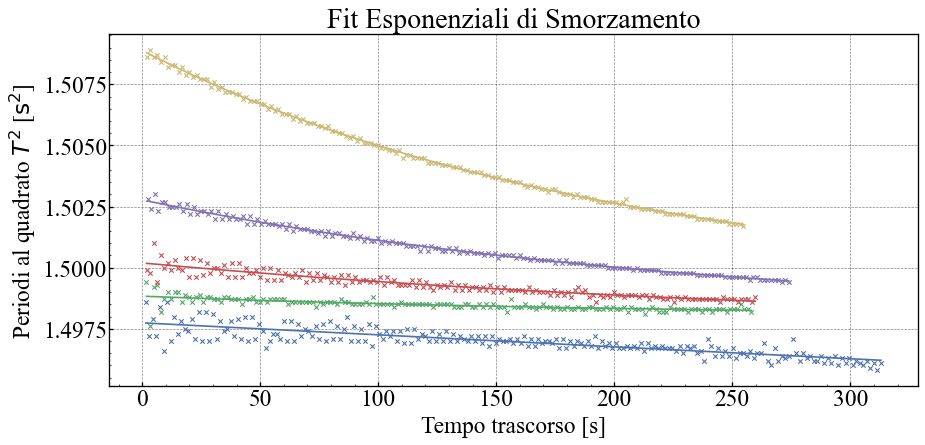

In [23]:
exp_func = lambda x, a, b, c: a * np.exp(-b * x) + c

with open(
    "data/misure fototraguardo, angoli diversi, 3-5-7-10-15 gradi.csv", "r"
) as file:
    data = pd.read_csv(file, delimiter=";", decimal=",").iloc[0:]

angles_used = [3, 5, 7, 10, 15]
asymptote_periods = list()
asymptote_std = list()

plt.subplots(figsize=(12, 6))
for i in range(0, 10, 2):
    X = data.iloc[:, i].dropna().to_numpy()
    Y = data.iloc[:, i + 1].dropna().to_numpy()
    plt.scatter(
        X, Y, marker="x", label=rf"{angles_used[i//2]}°"
    )

    params, cov = scipy.optimize.curve_fit(
        exp_func,
        X,
        Y,
        p0=[0.001, 0.001, 1.5],
        maxfev=3000,
        bounds=((0, 0, 1.4), (10, 1, 1.6)),
    )
    std = np.sqrt(np.diag(cov))

    print(f"~~~ Set con angolo {angles_used[i//2]}° ~~~")
    print(f"Ampiezza iniziale: \t{params[0]:.3e} ±{std[0]:.3e}")
    print(f"Smorzamento gamma: \t{params[1]:.3e} ±{std[1]:.3e}")
    print(f"Periodo all'asintoto: \t{params[2]:.3e} ±{std[2]:.3e}")
    asymptote_periods.append(params[2])
    asymptote_std.append(std[2])
    plt.plot(X, exp_func(X, *params), linewidth=1.5)

plt.title("Fit Esponenziali di Smorzamento")
plt.xlabel(r"Tempo trascorso [s]")
plt.ylabel(r"Periodi al quadrato $T^2$ [$\text{s}^2$]")
plt.savefig("images/Fit Esponenziale per Angoli Diversi.svg")

### Repeat linear regression for photogate with asymptote period

~~~ Set Fototraguardo (unico per tutti) con asintotico angoli diversi ~~~
Regression parameters: -0.004028±0.000076 2.367318±0.000080
g = 9802.0±186.1 mm/s^2


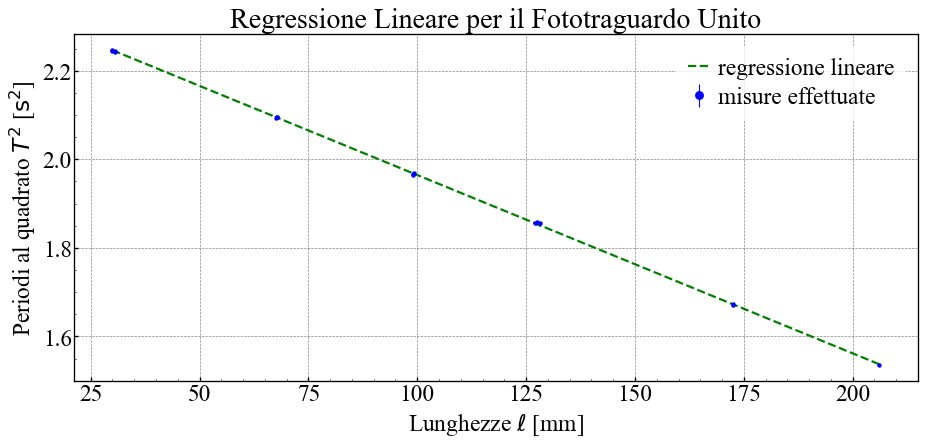

In [24]:
lungz = [30.56, 30.56, 30.00, 30.00] # mm # da excel
lunghezze_asint = list(lunghezze) + lungz

periods_asint = list(periods) + asymptote_periods[1:]

errors = list(err) + list(np.sqrt(np.square(asymptote_std[1:]) + np.square(xerr)))

lunghezze_asint, periods_asint, errors = np.array(lunghezze_asint), np.array(periods_asint), np.array(errors)
squared_periods_asympt = np.square(periods_asint)

params, cov = scipy.optimize.curve_fit(
    retta, lunghezze_asint, squared_periods_asympt, sigma=errors, absolute_sigma=True
)

g_value_asynt = -(4 * np.pi**2) / params[0]
g_uncert_asynt = -std[0] / params[0] * g_value_asynt

print

plt.subplots(figsize=(12, 6))
plt.errorbar(
    lunghezze_asint,
    squared_periods_asympt,
    fmt="b. ",
    yerr=errors,
    label="misure effettuate",
    markersize=8
)

plt.plot(
    lunghezze_asint, retta(lunghezze_asint, *params), ls="--", c="g", label="regressione lineare", linewidth=2
)

print(f"~~~ Set Fototraguardo (unico per tutti) con asintotico angoli diversi ~~~")
print("Regression parameters:", *[f"{param:.6f}±{errs:.6f}" for param, errs in zip(params, std)])
print(f"g = {g_value_asynt:.1f}±{g_uncert_asynt:.1f} mm/s^2")

plt.title("Regressione Lineare per il Fototraguardo Unito")
plt.xlabel(r"Lunghezze $\ell$ [mm]")
plt.ylabel(r"Periodi al quadrato $T^2$ [$\text{s}^2$]")
plt.legend()

plt.savefig("images/Regressione Lineare Fototraguardo2.svg")